# Working with Prompts/Prompt Template Assets for RAG task in watsonx.governance

This notebook should be run using with Runtime 22.2 & Python 3.10 or greater runtime environment. If you are viewing this in Watson Studio and do not see Python 3.10.x in the upper right corner of your screen, please update the runtime now.

The notebook will create a RAG prompt template asset in a given project, configure watsonx.governance to monitor that PTA and evaluate generative quality metrics and model health metrics. The notebook then promotes the prompt template asset to space and does the same evaluation.

If users wish to execute this notebook for task types other than RAG, please consult this document for guidance on evaluating prompt templates for the available task types.

Note : User can search for EDIT THIS and fill the inputs needed. Run your notebook on a CPD cluster with version above 5.0.0

## Prerequisite

* It requires service credentials for IBM watsonx.governance:
* Requires a CSV file containing the test data that needs to be evaluated
* Requires the ID of project in which you want to create the prompt template asset.
* Requires the ID of space to which you want to promote the prompt template asset.

### Contents

- [Setup](#settingup)
- [Create Prompt template](#prompt)
- [Prompt Setup](#ptatsetup)
- [Risk evaluations for prompt template asset subscription](#evaluate)
- [Display the Model Risk metrics](#mrmmetric)
- [Display the Generative AI Quality metrics](#genaimetrics)
- [Plot rougel and rougelsum metrics against records](#plotproject)
- [See factsheets information](#factsheetsspace)
- [Evaluate prompt template from space](#evaluatespace)
- [Promote prompt template asset to space](#promottospace)
- [Create deployment for prompt template asset in space](#ptadeployment)
- [Setup the prompt template asset in space](#ptaspace)
- [Score the model and configure monitors](#score)
- [Display the source attributions for a record](#attributions)
- [See factsheets information from space](#factsheetsproject)

## Setup <a name="settingup"></a>

Note: you may need to restart the kernel to use updated packages.

### Configure credentials

In [ ]:
use_cpd = "<EDIT THIS>"
project_id = "<EDIT THIS>"
space_id = "<EDIT THIS>"
if use_cpd:
    WOS_CREDENTIALS = {
        "url": "<EDIT THIS>",
        "username": "<EDIT THIS>",
        "password": "<EDIT THIS>",
        "apikey": "<EDIT THIS>"
    }

    BASE_URL = "<EDIT THIS>"
    CPD_URL = "<EDIT THIS>"
    SERVICE_INSTANCE_ID = "<EDIT THIS>"
    WML_BASE_URL = "<EDIT THIS>"
else:
    IAM_URL = "<EDIT THIS>"
    BASE_URL = "<EDIT THIS>"
    SERVICE_INSTANCE_ID = "<EDIT THIS>"
    WML_BASE_URL = "<EDIT THIS>"
    WOS_CREDENTIALS = {
         "url": "<EDIT THIS>",
         "username": "<EDIT THIS>",
         "password": "<EDIT THIS>"
    }

WML_CREDENTIALS = {
     "url": "<EDIT THIS>",
     "username": "<EDIT THIS>",
     "password" : "<EDIT THIS>",
     "instance_id": "<EDIT THIS>",
     "apikey": "<EDIT THIS>",
     "version" : "<EDIT THIS>"
}

In [ ]:
use_existing_space = True 

## Function to create the access token

This function generates an IAM access token using the provided credentials. The API calls for creating and scoring prompt template assets utilize the token generated by this function.

In [ ]:
import requests, json
use_cpd = False

def generate_access_token():
    headers={}
    if not use_cpd: 
        headers["Content-Type"] = "application/x-www-form-urlencoded"
        headers["Accept"] = "application/json"
        data = {
            "grant_type": "urn:ibm:params:oauth:grant-type:apikey",
            "apikey": WOS_CREDENTIALS["apikey"],
            "response_type": "cloud_iam"
        }
        response = requests.post(IAM_URL + "/identity/token", data=data, headers=headers)
        json_data = response.json()
        iam_access_token = json_data['access_token']
    else:
        headers["Content-Type"] = "application/json"
        headers["Accept"] = "application/json"
        data = {
            "username":WOS_CREDENTIALS["username"],
            "password":WOS_CREDENTIALS["password"]
        }
        data = json.dumps(data).encode("utf-8")
        url = WOS_CREDENTIALS["url"] + "/icp4d-api/v1/authorize"
        response = requests.post(url=url, data=data, headers=headers, verify=False)
        json_data = response.json()
        iam_access_token = json_data['token']      
        
    return iam_access_token

iam_access_token = generate_access_token()


# Create Prompt template <a name="prompt"></a>

Create a prompt template for a rag task

In [ ]:
url = f"{WML_BASE_URL}/wx/v1/prompts/"
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"project_id": project_id
}
payload = {
    "name": "RAG",
    "description": "RAG use case",
    "task_ids": [
        "retrieval_augmented_generation"
    ],
    "prompt_variables": {
        "context1": {},
        # "context2": {},
        # "context3": {},
        # "context4": {},
        "question": {},
        
    },
    "prompt": {
        "input": [
            [
                "Answer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:",
                ""
            ]
        ],
        "data": {
            "instruction": "Answer question from given contexts"
        },
        "model_id": "ibm/granite-13b-chat-v2"
    }
}

response = requests.post(url,json=payload, headers=headers, params= params, verify=True)
response_json = response.json()
response_json

{'id': '37f30735-dd1e-4af4-9460-7e39e97e8587',
 'name': 'RAG',
 'description': 'RAG use case',
 'created_at': 1730975171187,
 'created_by': 'IBMid-666002690O',
 'last_updated_at': 1730975171187,
 'last_updated_by': 'IBMid-666002690O',
 'resource_key': '689c93c5589b5867b5ca96d999556a4f08ab06374d495bddd2532d2b6484e643',
 'lock': {'locked': False},
 'input_mode': 'structured',
 'is_template': True,
 'prompt_variables': {'context1': {}, 'question': {}},
 'task_ids': ['retrieval_augmented_generation'],
 'prompt': {'input': [['Answer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:',
    '']],
  'data': {'instruction': 'Answer question from given contexts'},
  'model_id': 'ibm/granite-13b-chat-v2'}}

In [ ]:
project_pta_id = response_json["id"]
project_pta_id

'37f30735-dd1e-4af4-9460-7e39e97e8587'

In [ ]:
params = {"prompt_id": project_pta_id,
          "project_id": project_id
}
url = f"{WML_BASE_URL}/wx/v1/prompts/{project_pta_id}"
response = requests.get(url, headers=headers, params= params, verify=True)

# Prompt setup <a name="ptatsetup"></a>

In [ ]:
import requests, json
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/prompt_setup"

headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"prompt_template_asset_id": project_pta_id,
          "project_id": project_id
}

payload = """{
    "label_column": "answer",
    "operational_space_id": "development",
    "problem_type": "retrieval_augmented_generation",
    "input_data_type": "unstructured_text",
    "context_fields": ["context1"],
    "question_field": "question",
    "monitors" : {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 5,
            "metrics_configuration":{
                "rouge_score": {},
                "exact_match": {},
                "bleu": {},
                "unsuccessful_requests": {
                },
                "hap_input_score": {},
                "hap_score": {},
                "pii": {},
                "pii_input": {}
            }
        }
    }
}
}"""

json_payload = json.loads(payload)
json_payload

response = requests.post(url = url, json=json_payload,  params= params, headers=headers, verify=True)
response_json = response.json()
response_json

https://api.aiopenscale.cloud.ibm.com/openscale/21bf753c-434b-419e-9aa8-8114ca6ade5b/v2/prompt_setup


{'prompt_template_asset_id': '37f30735-dd1e-4af4-9460-7e39e97e8587',
 'start_time': '2024-11-07T10:26:15.864524Z',
 'status': {'state': 'RUNNING'},
 'project_id': 'b9687edf-c360-4f2f-a29c-6ac4ec509af8'}

In [ ]:
prompt_template_asset_id = response_json["prompt_template_asset_id"]

#prompt_template_asset_id = "55533a3b-04ce-4193-bfbb-1c4a4ded96f5"
prompt_template_asset_id

'37f30735-dd1e-4af4-9460-7e39e97e8587'

In [ ]:
response_json

{'prompt_template_asset_id': '5ebe7aab-b445-4db6-95af-c11ac999f648',
 'start_time': '2024-11-06T09:30:15.957071Z',
 'status': {'state': 'RUNNING'},
 'project_id': 'b9687edf-c360-4f2f-a29c-6ac4ec509af8'}

### Get the prompt setup status

In [ ]:
import time 
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/prompt_setup"
params={"project_id" : project_id,
        "prompt_template_asset_id": prompt_template_asset_id
       }
response = requests.get(url = url,headers=headers, params = params)
response_json = response.json()
response_json

for attempt in range(10):
    response = requests.get(url = url,headers=headers, params = params)
    response_json = response.json()
    state = response_json["status"]["state"]
    if state.lower() == "finished" or state == "error":
        break
    else:
        print(f"Attempt {attempt + 1}: Status is not finished. Retrying...")
        print(response.text)
        time.sleep(5)
else:
    print("Status did not change to 'finished/error' after 10 attempts.")
state

Attempt 1: Status is not finished. Retrying...
{"prompt_template_asset_id": "5ebe7aab-b445-4db6-95af-c11ac999f648", "start_time": "2024-11-06T09:30:15.957071Z", "status": {"state": "RUNNING"}, "project_id": "b9687edf-c360-4f2f-a29c-6ac4ec509af8"}

Attempt 2: Status is not finished. Retrying...
{"prompt_template_asset_id": "5ebe7aab-b445-4db6-95af-c11ac999f648", "start_time": "2024-11-06T09:30:15.957071Z", "status": {"state": "RUNNING"}, "project_id": "b9687edf-c360-4f2f-a29c-6ac4ec509af8"}

Attempt 3: Status is not finished. Retrying...
{"prompt_template_asset_id": "5ebe7aab-b445-4db6-95af-c11ac999f648", "start_time": "2024-11-06T09:30:15.957071Z", "status": {"state": "RUNNING"}, "project_id": "b9687edf-c360-4f2f-a29c-6ac4ec509af8"}



'FINISHED'

In [ ]:
response.text

'{"prompt_template_asset_id": "5ebe7aab-b445-4db6-95af-c11ac999f648", "start_time": "2024-11-06T09:30:15.957071Z", "status": {"state": "FINISHED"}, "project_id": "b9687edf-c360-4f2f-a29c-6ac4ec509af8", "end_time": "2024-11-06T09:30:37.469176Z", "service_provider_id": "cd25cc1b-dd87-4295-a652-01682ea17125", "deployment_id": "a060060d-e4ad-4bbb-b756-313ccc82b671", "subscription_id": "10c99f04-edb0-4233-873f-08f882e4a433", "mrm_monitor_instance_id": "28633695-b2e6-4e8b-a6e8-6eacd2aadd8f", "evaluation_tests": ["generative_ai_quality", "model_health"]}\n'

In [ ]:
response_json

{'prompt_template_asset_id': '5ebe7aab-b445-4db6-95af-c11ac999f648',
 'start_time': '2024-11-06T09:30:15.957071Z',
 'status': {'state': 'FINISHED'},
 'project_id': 'b9687edf-c360-4f2f-a29c-6ac4ec509af8',
 'end_time': '2024-11-06T09:30:37.469176Z',
 'service_provider_id': 'cd25cc1b-dd87-4295-a652-01682ea17125',
 'deployment_id': 'a060060d-e4ad-4bbb-b756-313ccc82b671',
 'subscription_id': '10c99f04-edb0-4233-873f-08f882e4a433',
 'mrm_monitor_instance_id': '28633695-b2e6-4e8b-a6e8-6eacd2aadd8f',
 'evaluation_tests': ['generative_ai_quality', 'model_health']}

### Read subscription id from prompt setup

In [ ]:
subscription_id = response_json["subscription_id"]
subscription_id

'10c99f04-edb0-4233-873f-08f882e4a433'

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/subscriptions/{subscription_id}/"
response = requests.get(url = url,headers=headers)
response_json = response.json()
pretty_json = json.dumps(response_json, indent=4)


In [ ]:
scoring_url = response_json["entity"]["deployment"]["url"]
scoring_url = scoring_url + "?version=2024-05-05"
scoring_url

'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/a060060d-e4ad-4bbb-b756-313ccc82b671/text/generation?version=2024-05-05'

In [ ]:
test_data_path = "rag_state_union.csv"

In [ ]:
import csv

feature_fields = ["context1", "question"]
prediction = "generated_text"

headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

pl_data = []
prediction_list = []
with open(test_data_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        request = {
            "parameters": {
                "template_variables": {
                }
            }
        }
        for each in feature_fields:
            request["parameters"]["template_variables"][each] = str(row[each])

        response = requests.post(scoring_url, json=request, headers=headers, verify=False).json()
        predicted_val = response["results"][0][prediction]
        prediction_list.append(predicted_val)
        record = {"request":request, "response":response}
        pl_data.append(record)


In [ ]:
response

{'model_id': 'ibm/granite-13b-chat-v2',
 'model_version': '2.1.0',
 'created_at': '2024-11-06T09:30:59.647Z',
 'results': [{'generated_text': ' The context does not provide information about the number of electric vehicle charging stations built.',
   'generated_token_count': 17,
   'input_token_count': 252,
   'stop_reason': 'eos_token'}],
 'system': {'warnings': [{'message': "Model 'ibm/granite-13b-chat-v2' is in deprecated state from 2024-11-04. It will be in withdrawn state from 2025-02-03.",
    'id': 'deprecation_warning',
    'more_info': 'https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-model-lifecycle.html?context=wx&audience=wdp'}]}}

In [ ]:
import copy

additional_pl_data = copy.copy(pl_data)
additional_pl_data *= 20
print("Generated {} additional payload data".format(len(additional_pl_data)))

Generated 100 additional payload data


### Listing all the available datamarts

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/data_marts/"
response = requests.get(url = url,headers=headers)
response_json = response.json()
pretty_json = json.dumps(response_json, indent=4)
response_json

{'data_marts': [{'entity': {'database_configuration': {'credentials': {'secret_id': 'bdb5ea12-5e62-472d-9d0e-704d29833f5d'},
     'database_type': 'postgresql',
     'location': {'schema_name': '21bf753c-434b-419e-9aa8-8114ca6ade5b'}},
    'internal_database': True,
    'service_instance_crn': 'crn:v1:bluemix:public:aiopenscale:us-south:a/d49e4dd2ea584a1d82c4ddc3f8f08c9f:21bf753c-434b-419e-9aa8-8114ca6ade5b::',
    'status': {'state': 'active'}},
   'metadata': {'created_at': '2024-09-25T21:56:35.385Z',
    'created_by': 'IBMid-666002690O',
    'crn': 'crn:v1:bluemix:public:aiopenscale:us-south:a/d49e4dd2ea584a1d82c4ddc3f8f08c9f:21bf753c-434b-419e-9aa8-8114ca6ade5b:data_mart:21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'id': '21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'modified_at': '2024-09-25T21:56:37.531Z',
    'modified_by': 'IBMid-666002690O',
    'url': '/v2/data_marts/21bf753c-434b-419e-9aa8-8114ca6ade5b'}}]}

### Openscale instance mapping with the project

When the authentication is on CPD then we need to add additional step of mapping the project_id/space_id to an OpenScale instance.

In [ ]:
if use_cpd:
    url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/instance_mappings/"
    target = {
        "target_type" : "project",
        "target_id": project_id
    }
    payload = {
        "service_instance_id": SERVICE_INSTANCE_ID,
        "target": target
    }
        
    response = requests.post(url, json=payload, headers=headers, verify=False)   

## Setup the prompt template asset in project for evaluation with supported monitor dimensions

The prompt template assets from project is only supported with `development` operational space ID. Running the below cell will create a development type subscription from the prompt template asset created within the project.

The available parameters that can be passed for `execute_prompt_setup` function are:

 * `prompt_template_asset_id` : Id of prompt template asset for which subscription needs to be created.
 * `label_column` :  The name of the column containing the ground truth or actual labels.
 * `project_id` : The GUID of the project.
 * `space_id` : The GUID of the space.
 * `deployment_id` : (optional) The GUID of the deployment.
 * `operational_space_id` : The rank of the environment in which the monitoring is happening. Accepted values are `development`, `pre_production`, `production`.
 * `problem_type` : (optional) The task type to monitor for the given prompt template asset.
 * `classification_type` : The classification type `binary`/`multiclass` applicable only for `classification` problem (task) type.
 * `input_data_type` : The input data type.
 * `supporting_monitors` : Monitor configuration for the subscription to be created.
 * `background_mode` : When `True`, the promt setup operation will be executed in the background

 #### Faithfulness parameters
| Parameter | Description | Default Value |
|:-|:-|:-|
| attributions_count [Optional]| Source attributions are computed for each sentence in the generated answer. Source attribution for a sentence is the set of sentences in the context which contributed to the LLM generating that sentence in the answer.  The attributions_count parameter specifies the number of sentences in the context which need to be identified for attributions.  E.g., if the value is set to 2, then we will find the top 2 sentences from the context as source attributions. | 3 |
| ngrams [Optional]| The number of sentences to be grouped from the context when computing faithfulness score. These grouped sentences will be shown in the attributions. Having a very high value of ngrams might lead to having lower faithfulness scores due to dispersion of data and inclusion of unrelated sentences in the attributions. Having a very low value might lead to increase in metric computation time and attributions not capturing the all the aspects of the answer. | 2 |

#### Unsuccessful requests parameters
| Parameter | Description | Default Value |
|:-|:-|:-|
| unsuccessful_phrases [Optional]| The list of phrases to be used for comparing the model output to determine whether the request is unsuccessful or not. | ["i don't know", "i do not know", "i'm not sure", "i am not sure", "i'm unsure", "i am unsure", "i'm uncertain", "i am uncertain", "i'm not certain", "i am not certain", "i can't fulfill", "i cannot fulfill"] |

## Get MRM monitor instances of the development subscription
The following cell lists the MRM monitors present in the development subscription along with their respective statuses and other details.

In [ ]:
# read monitor instance id
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitor_instances"
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"target.target_id": subscription_id,
          "monitor_definition_id": "mrm"
}

response = requests.get(url, headers=headers, params= params, verify=True)
response_json = response.json()

### Read the MRM monitor instance id

Evaluating the test data against the prompt template subscription requires the monitor instance ID of MRM.

In [ ]:
monitor_instance_id = response_json["monitor_instances"][0]["metadata"]["id"]
monitor_instance_id 

'28633695-b2e6-4e8b-a6e8-6eacd2aadd8f'

# Risk evaluations for PTA subscription <a name="evaluate"></a>

### Evaluate the prompt template subscription

For the risk assessment of a development type subscription the user needs to have an evaluation dataset. The risk evaluation function takes the evaluation dataset path as a parameter for evaluation of the configured metric dimensions. If there is a discrepancy between the feature columns in the subscription and the column names in the uploading CSV, users has the option to supply a mapping JSON file to associate the CSV column names with the feature column names in the subscription.


**Note:* If you are running this notebook from Watson studio, you may first need to upload your test data to studio and run code snippet to download feedback data file from project to local directory, and you need to use watson studio sdk api <access_project_or_space> to acheive this , and you need to give the api key for the platform you are running the notebook

In [ ]:
# !rm rag_state_union.csv
!wget https://raw.githubusercontent.com/IBM/watson-openscale-samples/main/IBM%20Cloud/WML/assets/data/watsonx/rag_state_union.csv

zsh:1: command not found: wget


In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitoring_services/mrm/monitor_instances/{monitor_instance_id}/risk_evaluations"

headers1={}
headers1["Authorization"] = "Bearer {}".format(iam_access_token)
test_data_path = "rag_state_union.csv"
params = {"test_data_set_name": "rag_state_union"
         }
with open(test_data_path, "rb") as file:
    files2 = [("data",("rag_state_union.csv", file))]
    response = requests.post(url = url, files=files2, headers=headers1, params=params, verify=True)
response

<Response [202]>

### Read the risk evaluation response

After initiating the risk evaluation, the evaluation results are now available for review

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitoring_services/mrm/monitor_instances/{monitor_instance_id}/risk_evaluations"

params = {}
response =  requests.get(url, headers=headers,verify=True)
response_json = response.json()
response_json

for attempt in range(40):
    response = requests.get(url = url,headers=headers, params = params)
    response_json = response.json()
    state = response_json["entity"]["status"]["state"]
    if state.lower() == "finished" or state == "error":
        break
    else:
        print(f"Attempt {attempt + 1}: Status is not finished. Retrying...{state}")
        time.sleep(5)
else:
    print("Status did not change to 'finished/error' after 40 attempts.")
state

Attempt 1: Status is not finished. Retrying...UPLOAD_IN_PROGRESS
Attempt 2: Status is not finished. Retrying...UPLOAD_IN_PROGRESS
Attempt 3: Status is not finished. Retrying...UPLOAD_IN_PROGRESS
Attempt 4: Status is not finished. Retrying...running
Attempt 5: Status is not finished. Retrying...running
Attempt 6: Status is not finished. Retrying...running


'finished'

In [ ]:
measurement_id = response_json["entity"]["parameters"]["measurement_id"]
measurement_id

'10f7f86a-18ad-4750-99ed-1c30e0078a7e'

# Display the Model Risk metrics <a name="mrmmetric"></a>

Having calculated the measurements for the Foundation Model subscription, the MRM metrics generated for this subscription are now available for your review.

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitor_instances/{monitor_instance_id}/measurements/{measurement_id}"

response = requests.get(url = url,headers=headers)
response_json = response.json()
pretty_json = json.dumps(response_json, indent=4)
response_json

{'entity': {'asset_revision': None,
  'issue_count': 0,
  'monitor_definition_id': 'mrm',
  'monitor_instance_id': '28633695-b2e6-4e8b-a6e8-6eacd2aadd8f',
  'run_id': '00e40de7-f69c-4854-b3de-9ec3b92919a9',
  'sources': [{'data': {'evaluation_result': {'evaluation_date': '2024-11-06T09:31:48.255000Z',
      'run_status': 'EVALUATION_FINISHED',
      'test_data_records': 5,
      'test_data_set_name': 'rag_state_union',
      'tests': [{'breach_status': 'RED',
        'evaluation_id': '00e40de7-f69c-4854-b3de-9ec3b92919a9',
        'fb_evaluated_num_records': 5,
        'issues_count': 6,
        'measurement_id': '4246241f-019c-4338-ba10-08a0fddfaf29',
        'metric_timestamp': '2024-11-06T09:32:04.426231Z',
        'monitor_definition_id': 'generative_ai_quality',
        'monitor_instance_id': '8cc15bf1-f143-4500-8669-36a287351f54',
        'outcome': 'FAIL',
        'status': 'FINISHED',
        'summary': {'feedback': {'end_time': '2024-11-06T09:31:37.270Z',
          'issues_cou

In [ ]:
tests  = response_json["entity"]["sources"][0]["data"]["evaluation_result"]["tests"]
for test in tests:
    if test["monitor_definition_id"] == "generative_ai_quality":
        monitor_instance_id = test["monitor_instance_id"]
        measurement_id_genai = test["measurement_id"]

#### Get the generative ai quality moniter id

In [ ]:
# read monitor instance id
import requests, json
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitor_instances"
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"target.target_id": subscription_id,
          "monitor_definition_id": "generative_ai_quality"
}

response = requests.get(url, headers=headers, params= params, verify=True)
response_json = response.json()
response_json


{'monitor_instances': [{'entity': {'data_mart_id': '21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'managed_by': 'user',
    'monitor_definition_id': 'generative_ai_quality',
    'parameters': {'last_processed_ts': '2024-11-06T09:31:52.195226Z',
     'metrics_configuration': {'bleu': {},
      'exact_match': {},
      'hap_input_score': {},
      'hap_score': {},
      'pii': {},
      'pii_input': {},
      'rouge_score': {},
      'unsuccessful_requests': {}},
     'min_sample_size': 5,
     'prompt_template_details': {'inference_input_string': 'Answer question from given contexts\n\nAnswer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:',
      'input': [['Answer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:',
        '']]}},
    'status': {'state': 'active'},
    'target': {'targ

In [ ]:
monitor_instances_id = response_json["monitor_instances"][0]["metadata"]["id"]
monitor_instances_id

'8cc15bf1-f143-4500-8669-36a287351f54'

# Display the Generative AI Quality metrics <a name="genaimetrics"></a>

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitor_instances/{monitor_instances_id}/measurements/{measurement_id_genai}


response = requests.get(url = url,headers=headers)
response_json = response.json()
#response_json
response_json = response_json
pretty_json = json.dumps(response_json, indent=4)
#print(pretty_json)
response_json

{'entity': {'asset_revision': '10c99f04-edb0-4233-873f-08f882e4a433',
  'issue_count': 22,
  'monitor_definition_id': 'generative_ai_quality',
  'monitor_instance_id': '8cc15bf1-f143-4500-8669-36a287351f54',
  'run_id': '4d20f27b-8faa-4b19-9cce-40f843f643a9',
  'sources': [{'data': {'feedback': {'end_time': '2024-11-06T09:31:37.270Z',
      'failed_metric_ids': [],
      'issue_count': 6,
      'metrics_href': 'https://api.aiopenscale.cloud.ibm.com/openscale/21bf753c-434b-419e-9aa8-8114ca6ade5b/v2/data_sets/cab7407c-da0d-4bb2-a39b-9e49900db2dc/records?filter=run_id:eq:4d20f27b-8faa-4b19-9cce-40f843f643a9,computed_on:eq:feedback',
      'start_time': '2024-11-06T09:31:37.270Z',
      'total_records_processed': 5}},
    'id': 'evaluation_summary',
    'type': 'evaluation_summary'},
   {'data': {'fields': ['metric_id',
      'metric_value_range',
      'count',
      'row_percent'],
     'values': [['rouge2', [0.104, 0.152], 1, 20.0],
      ['rouge2', [0.152, 0.199], 0, 0.0],
      ['roug

In [ ]:
url = response_json["entity"]["sources"][0]["data"]["feedback"]["metrics_href"]

#### Show Metrics computed using feedback data

In [ ]:
response = requests.get(url = url,headers=headers)
response_json = response.json()
response_json

{'records': [{'entity': {'values': {'hap_input_score': 0.0009890641085803509,
     'rouge2': 0.4915,
     'pii_entities': [],
     'scoring_id': 'MRM_1a3f93ee-0dee-4c9a-94d3-2a9dc4cc2fc1-0',
     'computed_on': 'feedback',
     'scoring_timestamp': '2024-11-06T09:31:37.270Z',
     'rougelsum': 0.6333,
     'hap_score': 0.0018304836703464389,
     'pii_input_entities': [],
     'pii': 0.0,
     'hap_input_score_entities': None,
     'hap_score_positions': None,
     'bleu': 0.39902400645247116,
     'run_id': '4d20f27b-8faa-4b19-9cce-40f843f643a9',
     'pii_input_positions': None,
     'pii_positions': None,
     'rougel': 0.5833,
     'exact_match': 0.0,
     'unsuccessful_requests': 0.0,
     'hap_score_entities': None,
     'pii_input': 0.0,
     'hap_input_score_positions': None,
     'rouge1': 0.6333},
    'annotations': None},
   'metadata': {'created_at': '2024-11-06T09:31:37.270Z',
    'created_by': 'IBMid-666002690O',
    'crn': 'crn:v1:bluemix:public:aiopenscale:us-south:a/d4

## Display the Generative AI Quality metrics

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/data_sets"
params = {
    "target.target_id":subscription_id,
    "type":"gen_ai_quality_metrics"
}
response = requests.get(url = url,headers=headers, params=params)
response_json = response.json()
response_json

{'data_sets': [{'entity': {'data_mart_id': '21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'data_schema': {'fields': [{'metadata': {'modeling_role': 'record-id',
        'primary_key': True},
       'name': 'scoring_id',
       'nullable': False,
       'type': 'string'},
      {'metadata': {'modeling_role': 'record-timestamp'},
       'name': 'scoring_timestamp',
       'nullable': False,
       'type': 'timestamp'},
      {'metadata': {'columnInfo': {'columnIndex': 'DEFAULT'}},
       'name': 'run_id',
       'nullable': False,
       'type': 'string'},
      {'metadata': {},
       'name': 'computed_on',
       'nullable': False,
       'type': 'string'},
      {'metadata': {},
       'name': 'hap_input_score',
       'nullable': True,
       'type': 'double'},
      {'metadata': {'columnInfo': {'columnLength': 32000}},
       'name': 'hap_input_score_entities',
       'nullable': True,
       'type': {'containsNull': True,
        'elementType': 'string',
        'type': 'array'}},
   

In [ ]:
payload_dataset_id2 = response_json["data_sets"][0]["metadata"]["id"]
payload_dataset_id2

'cab7407c-da0d-4bb2-a39b-9e49900db2dc'

## Display record level metrics for Generative AI Quality 

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/data_sets/{payload_dataset_id2}/records"
params = {

    "include_total_count":"true",
    "limit":1
}
response = requests.get(url = url,headers=headers, params = params)
response_json = response.json()
#response_json
pretty_json = json.dumps(response_json, indent=4)


In [ ]:
genaiq_dataset_id = response_json["records"][0]["metadata"]["id"]
genaiq_dataset_id

'MRM_1a3f93ee-0dee-4c9a-94d3-2a9dc4cc2fc1-0'

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/data_sets/{payload_dataset_id2}/records/"
response = requests.get(url = url,headers=headers)
response_json = response.json()
pretty_json = json.dumps(response_json, indent=4)
response_json["records"]

[{'entity': {'values': {'hap_input_score': 0.0009890641085803509,
    'rouge2': 0.4915,
    'pii_entities': [],
    'scoring_id': 'MRM_1a3f93ee-0dee-4c9a-94d3-2a9dc4cc2fc1-0',
    'computed_on': 'feedback',
    'scoring_timestamp': '2024-11-06T09:31:37.270Z',
    'rougelsum': 0.6333,
    'hap_score': 0.0018304836703464389,
    'pii_input_entities': [],
    'pii': 0.0,
    'hap_input_score_entities': None,
    'hap_score_positions': None,
    'bleu': 0.39902400645247116,
    'run_id': '4d20f27b-8faa-4b19-9cce-40f843f643a9',
    'pii_input_positions': None,
    'pii_positions': None,
    'rougel': 0.5833,
    'exact_match': 0.0,
    'unsuccessful_requests': 0.0,
    'hap_score_entities': None,
    'pii_input': 0.0,
    'hap_input_score_positions': None,
    'rouge1': 0.6333},
   'annotations': None},
  'metadata': {'created_at': '2024-11-06T09:31:37.270Z',
   'created_by': 'IBMid-666002690O',
   'crn': 'crn:v1:bluemix:public:aiopenscale:us-south:a/d49e4dd2ea584a1d82c4ddc3f8f08c9f:21bf753

# Plot faithfulness and answer relevance metrics against records <a name="plotspace"></a>

In [ ]:
record = response_json["records"][0]["entity"]["values"]
scoring_id = record.get("scoring_id")
result = response_json

In [ ]:
result

{'records': [{'entity': {'values': {'hap_input_score': 0.0009890641085803509,
     'rouge2': 0.4915,
     'pii_entities': [],
     'scoring_id': 'MRM_1a3f93ee-0dee-4c9a-94d3-2a9dc4cc2fc1-0',
     'computed_on': 'feedback',
     'scoring_timestamp': '2024-11-06T09:31:37.270Z',
     'rougelsum': 0.6333,
     'hap_score': 0.0018304836703464389,
     'pii_input_entities': [],
     'pii': 0.0,
     'hap_input_score_entities': None,
     'hap_score_positions': None,
     'bleu': 0.39902400645247116,
     'run_id': '4d20f27b-8faa-4b19-9cce-40f843f643a9',
     'pii_input_positions': None,
     'pii_positions': None,
     'rougel': 0.5833,
     'exact_match': 0.0,
     'unsuccessful_requests': 0.0,
     'hap_score_entities': None,
     'pii_input': 0.0,
     'hap_input_score_positions': None,
     'rouge1': 0.6333},
    'annotations': None},
   'metadata': {'created_at': '2024-11-06T09:31:37.270Z',
    'created_by': 'IBMid-666002690O',
    'crn': 'crn:v1:bluemix:public:aiopenscale:us-south:a/d4

In [ ]:
x = []
y_faithfulness = []
y_answer_relevance = []
for each in result["records"]:
    x.append(each["metadata"]["id"][-5:]) # Reading only last 5 characters to fit in the display
    y_faithfulness.append(each["entity"]["values"]["hap_input_score"])
    y_answer_relevance.append(each["entity"]["values"]["hap_score"])

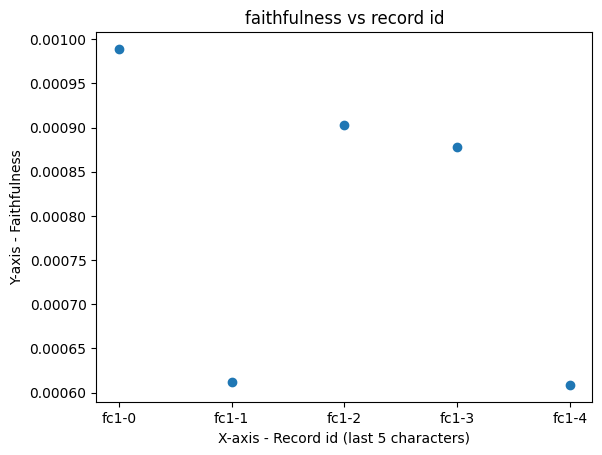

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x, y_faithfulness, marker='o')

plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - Faithfulness')
plt.title('faithfulness vs record id')

plt.show()

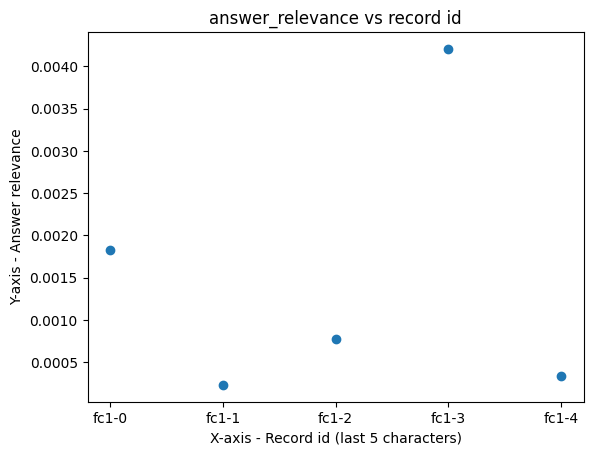

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x, y_answer_relevance, marker='o')

# Adding labels and title
plt.xlabel('X-axis - Record id (last 5 characters)')
plt.ylabel('Y-axis - Answer relevance')
plt.title('answer_relevance vs record id')

# Display the graph
plt.show()

# See factsheets information <a name="factsheetsspace"></a>

In [ ]:
factsheets_url = "{}/wx/prompt-details/{}/factsheet?context=wx&project_id={}".format(WML_CREDENTIALS["url"],project_pta_id, project_id)
print("User can navigate to the published facts in project {}".format(factsheets_url))

User can navigate to the published facts in project https://us-south.ml.cloud.ibm.com/wx/prompt-details/5ebe7aab-b445-4db6-95af-c11ac999f648/factsheet?context=wx&project_id=b9687edf-c360-4f2f-a29c-6ac4ec509af8


# Evaluate Prompt template from space <a name="evaluatespace"></a>

Here is a quick recap of what we have done so far.

1. We've created a prompt template asset in project.
2. We've created a `development` type subscription of prompt template asset in OpenScale.
3. Configured monitors supported by OpenScale for the subscriptions.
4. We've performed risk evaluations against the PTA susbscription with a sample set of test data.
5. Displayed the metrics generated with the risk evaluation.
6. Displayed the factsheets information for the subscription.

Now, we can promote the created prompt template asset to space and perform similar actions.

# Promote PTA to space <a name="promottospace"></a> 

Below cell promotes the prompt template asset from the project to the space.

In [ ]:
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)
verify = True

DATAPLATFORM_URL = WOS_CREDENTIALS["url"]
verify = False
url = "{}/v2/assets/{}/promote".format(DATAPLATFORM_URL ,project_pta_id)

params = {
    "project_id":project_id
}

payload = {
    "space_id": space_id
}
response = requests.post(url, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()
json_data
space_pta_id = json_data["metadata"]["asset_id"]
space_pta_id

'25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51'

In [ ]:
response.text

'{"metadata":{"space_id":"29599bf8-5a6c-4398-a87b-60da22d96dcd","usage":{"last_updated_at":"2024-11-07T10:26:31Z","last_updater_id":"IBMid-666002690O","last_update_time":1730975191867,"last_accessed_at":"2024-11-07T10:26:31Z","last_access_time":1730975191867,"last_accessor_id":"IBMid-666002690O","access_count":0},"rov":{"mode":0,"collaborator_ids":{},"member_roles":{"IBMid-666002690O":{"user_iam_id":"IBMid-666002690O","roles":["OWNER"]}}},"name":"RAG","description":"RAG use case","asset_type":"wx_prompt","origin_country":"us","resource_key":"689c93c5589b5867b5ca96d999556a4f08ab06374d495bddd2532d2b6484e643","rating":0.0,"total_ratings":0,"catalog_id":"b0b49bda-0968-45d2-af21-64cca1db3fde","created":1730975191867,"created_at":"2024-11-07T10:26:31Z","owner_id":"IBMid-666002690O","size":275,"version":2.0,"asset_state":"available","asset_attributes":["wx_prompt","modelfacts_system","modelfacts_user"],"asset_id":"25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51","source_asset":{"action":"promote","catal

# Create deployment for prompt template asset in space <a name="ptadeployment"></a>

To create a subscription from space, it is necessary to create a deployment for prompt template assets in spaces.

In [ ]:
DEPLOYMENTS_URL = WML_CREDENTIALS["url"] + "/ml/v4/deployments"

serving_name = "rag_qa_deployment13" # eg: summary_deployment

payload = {
    "prompt_template": {
      "id": space_pta_id
    },
    "online": {
       "parameters": {
         "serving_name": serving_name
       }
    },
    "base_model_id": "ibm/granite-13b-chat-v2",
    "description": "rag qa deployment",
    "name": "rag qa deployment",
    "space_id": space_id
}

version = "2024-05-05" # The version date for the API of the form YYYY-MM-DD. Example : 2023-07-07
params = {
    "version":version,
    "space_id":space_id
}

response = requests.post(DEPLOYMENTS_URL, json=payload, headers=headers, params = params, verify = verify)
json_data = response.json()


if "metadata" in json_data:
    deployment_id = json_data["metadata"]["id"]
    print(deployment_id)
else:
    print(json_data)

5fa2bb9d-159d-46a6-b3bc-8d3fb493a574


# Setup the prompt template asset in space for evaluation with supported monitor dimensions <a name="ptaspace"></a>

The prompt template assets from space is only supported with [`pre_production` and `production`] operational space IDs. Running the below cell will create a `production` type subscription from the prompt template asset promoted to the space. The `problem_type` value should depend on the task type specified in the prompt template asset.

# Create Prompt setup <a name="prompt"></a>

In [ ]:
import requests, json
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/prompt_setup"

headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"prompt_template_asset_id": space_pta_id,
          "space_id": space_id,
          "deployment_id": deployment_id
}

payload = """{
    "label_column": "answer",
    "operational_space_id": "production",
    "problem_type": "retrieval_augmented_generation",
    "input_data_type": "unstructured_text",
    "context_fields": ["context1"],
    "question_field": "question",
    "monitors" : {
    "generative_ai_quality": {
        "parameters": {
            "min_sample_size": 5,
            "metrics_configuration":{
                "rouge_score": {},
                "exact_match": {},
                "bleu": {},
                "unsuccessful_requests": {
                },
                "hap_input_score": {},
                "hap_score": {},
                "pii": {},
                "pii_input": {}
            }
        }
    },
    "drift_v2": {
            "thresholds": [
            {
                "metric_id": "confidence_drift_score",
                "type": "upper_limit",
                "value": 0.05
            },
            {
                "metric_id": "prediction_drift_score",
                "type": "upper_limit",
                "value": 0.05
            },
            {
                "metric_id": "input_metadata_drift_score",
                "specific_values": [
                    {
                        "applies_to": [
                            {
                                "type": "tag",
                                "value": "subscription",
                                "key": "field_type"
                            }
                        ],
                        "value": 0.05
                    }
                ],
                "type": "upper_limit"
            },
            {
                "metric_id": "output_metadata_drift_score",
                "specific_values": [
                    {
                        "applies_to": [
                            {
                                "type": "tag",
                                "value": "subscription",
                                "key": "field_type"
                            }
                        ],
                        "value": 0.05
                    }
                ],
                "type": "upper_limit"
            }
        ],
        "parameters": {
            "min_sample_size": 5

        }
    }
}
}"""
json_payload = json.loads(payload)
json_payload

response = requests.post(url = url, json=json_payload,  params= params, headers=headers, verify=True)
response_json = response.json()
response_json

https://api.aiopenscale.cloud.ibm.com/openscale/21bf753c-434b-419e-9aa8-8114ca6ade5b/v2/prompt_setup


{'prompt_template_asset_id': '25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51',
 'start_time': '2024-11-07T10:26:51.489146Z',
 'status': {'state': 'RUNNING'},
 'space_id': '29599bf8-5a6c-4398-a87b-60da22d96dcd',
 'deployment_id': '5fa2bb9d-159d-46a6-b3bc-8d3fb493a574'}

In [ ]:
prompt_template_asset_id = response_json["prompt_template_asset_id"]

#prompt_template_asset_id = "55533a3b-04ce-4193-bfbb-1c4a4ded96f5"
prompt_template_asset_id

'25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51'

With the below cell, users can read the prompt setup task and check its status

### Get the prompt setup status

In [ ]:
import time 
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/prompt_setup"
params={
        "prompt_template_asset_id": prompt_template_asset_id,
        "space_id" : space_id,
        "deployment_id": deployment_id
       }
response = requests.get(url = url,headers=headers, params = params)
response_json = response.json()
response_json

for attempt in range(10):
    response = requests.get(url = url,headers=headers, params = params)
    response_json = response.json()
    state = response_json["status"]["state"]
    if state.lower() == "finished" or state == "error":
        break
    else:
        print(f"Attempt {attempt + 1}: Status is not finished. Retrying...")
        print(response.text)
        time.sleep(5)
else:
    print("Status did not change to 'finished/error' after 10 attempts.")
state

Attempt 1: Status is not finished. Retrying...
{"prompt_template_asset_id": "25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51", "start_time": "2024-11-07T10:26:51.489146Z", "status": {"state": "RUNNING"}, "space_id": "29599bf8-5a6c-4398-a87b-60da22d96dcd", "deployment_id": "5fa2bb9d-159d-46a6-b3bc-8d3fb493a574"}

Attempt 2: Status is not finished. Retrying...
{"prompt_template_asset_id": "25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51", "start_time": "2024-11-07T10:26:51.489146Z", "status": {"state": "RUNNING"}, "space_id": "29599bf8-5a6c-4398-a87b-60da22d96dcd", "deployment_id": "5fa2bb9d-159d-46a6-b3bc-8d3fb493a574"}

Attempt 3: Status is not finished. Retrying...
{"prompt_template_asset_id": "25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51", "start_time": "2024-11-07T10:26:51.489146Z", "status": {"state": "RUNNING"}, "space_id": "29599bf8-5a6c-4398-a87b-60da22d96dcd", "deployment_id": "5fa2bb9d-159d-46a6-b3bc-8d3fb493a574"}



'FINISHED'

### Read subscription id from prompt setup

In [ ]:
subscription_id = response_json["subscription_id"]
subscription_id

'429ea7ce-f2da-4317-a457-8924be5b3b2c'

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/subscriptions/{subscription_id}/"
response = requests.get(url = url,headers=headers)
response_json = response.json()
pretty_json = json.dumps(response_json, indent=4)

### Score the PTA deployment

In [ ]:
scoring_url = response_json["entity"]["deployment"]["url"]
scoring_url = scoring_url + "?version=2024-05-05"
scoring_url

'https://us-south.ml.cloud.ibm.com/ml/v1/deployments/5fa2bb9d-159d-46a6-b3bc-8d3fb493a574/text/generation?version=2024-05-05'

# Score the model so that we can configure monitors <a name="score"></a>

Now that the WML service has been bound and the subscription has been created, we need to score the prompt template asset. User needs to generate the test data content in JSON format from the downloaded CSV file. This is used to construct the payload for scoring the deployment.

In [ ]:
import csv

feature_fields = ["context1", "question"]
prediction = "generated_text"

headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

pl_data = []
prediction_list = []
with open(test_data_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        request = {
            "parameters": {
                "template_variables": {
                }
            }
        }
        for each in feature_fields:
            request["parameters"]["template_variables"][each] = str(row[each])

        response = requests.post(scoring_url, json=request, headers=headers, verify=False).json()
        predicted_val = response["results"][0][prediction]
        prediction_list.append(predicted_val)
        record = {"request":request, "response":response}
        pl_data.append(record)
pl_data

[{'request': {'parameters': {'template_variables': {'context1': 'Last month, I announced our plan to supercharge  the Cancer Moonshot that President Obama asked me to lead six years ago. Our goal is to cut the cancer death rate by at least 50% over the next 25 years, turn more cancers from death sentences into treatable diseases.  More support for patients and families. To get there, I call on Congress to fund ARPA-H, the Advanced Research Projects Agency for Health. It’s based on DARPA—the Defense Department project that led to the Internet, GPS, and so much more.  ARPA-H will have a singular purpose—to drive breakthroughs in cancer, Alzheimer’s, diabetes, and more. A unity agenda for the nation. We can do this. My fellow Americans—tonight , we have gathered in a sacred space—the citadel of our democracy. In this Capitol, generation after generation, Americans have debated great questions amid great strife, and have done great things. We have fought for freedom, expanded liberty, defe

### Generating additional payload data to enable drift

To enable drift there should be minimum 100 records in the payload table. The below cell duplicates the scored records and create another 100 records for adding to the payload table

In [ ]:
import copy

additional_pl_data = copy.copy(pl_data)
additional_pl_data *= 20
print("Generated {} additional payload data".format(len(additional_pl_data)))

Generated 100 additional payload data


In [ ]:
payload = '''[
    {

            "fields": ["original_text", "summary", "_original_prediction"],
            "values": [
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.", ""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""],
                ["we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.", "give us feedback and we can do whatever we want with it.",""]
            ]
    }

]'''

json_payload = json.loads(payload)
json_payload

[{'fields': ['original_text', 'summary', '_original_prediction'],
  'values': [['we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use copy modify create derivative works based upon and otherwise exploit the feedback for any purpose.',
    'give us feedback and we can do whatever we want with it.',
    ''],
   ['we welcome feedback comments and suggestions for improvements to the services feedback. you can submit feedback by reaching out to us on facebook twitter or google. you grant to us a nonexclusive worldwide perpetual irrevocable fully paid royalty free sublicensable and transferable license under any and all intellectual property rights that you own or control to use co

### Adding payload data

Below cell reads the payload data set id from the subscription. 

In [ ]:

url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/data_sets/{feedback_dataset_id}/records"
response = requests.post(url = url,headers=headers, json=json_payload)
response_json = response.json()
response_json

{'state': 'preparing'}

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/data_sets/{feedback_dataset_id}/records"
params = {

    "include_total_count":"true",
    "limit":1
}
response = requests.get(url = url,headers=headers, params = params)
response_json = response.json()
response_json["total_count"]

50

## Show all the monitor instances of the production subscription
The following cell lists the monitors present in the production subscription along with their respective statuses and other details. Please wait for all the monitors to be in active state before proceeding further.

In [ ]:
# read monitor instance id
import requests, json
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitor_instances"
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"target.target_id": subscription_id,
          "monitor_definition_id": "mrm"
}

response = requests.get(url, headers=headers, params= params, verify=True)
response_json = response.json()
response_json

{'monitor_instances': [{'entity': {'data_mart_id': '21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'managed_by': 'user',
    'monitor_definition_id': 'mrm',
    'parameters': {'deployment_id': '5fa2bb9d-159d-46a6-b3bc-8d3fb493a574',
     'prompt_template_asset_id': '25ddf8fb-cafb-4cd8-9985-c0aabcdcbe51',
     'prompt_template_details': {'pta_resource_key': '689c93c5589b5867b5ca96d999556a4f08ab06374d495bddd2532d2b6484e643'},
     'space_id': '29599bf8-5a6c-4398-a87b-60da22d96dcd',
     'user_iam_id': 'IBMid-666002690O'},
    'schedule': {'repeat_interval': 60,
     'repeat_type': 'minute',
     'repeat_unit': 'minute',
     'status': 'enabled'},
    'schedule_id': 'd2dd0e99-144e-4b76-b931-4e0e4d5b7f06',
    'status': {'state': 'active'},
    'target': {'target_id': '429ea7ce-f2da-4317-a457-8924be5b3b2c',
     'target_type': 'subscription'}},
   'metadata': {'created_at': '2024-11-07T10:27:08.746Z',
    'created_by': 'iam-ServiceId-b317a8da-d926-496e-b0ca-6bcc57f556ae',
    'crn': 'crn:v1:bl

In [ ]:
monitor_instance_id = response_json["monitor_instances"][0]["metadata"]["id"]
monitor_instance_id 

'1ce0f351-83e8-4667-af5a-7cba3f9391b8'

#### Get the generative ai quality moniter id

In [ ]:
import requests, json
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitor_instances"
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"target.target_id": subscription_id,
          "monitor_definition_id": "generative_ai_quality"
}

response = requests.get(url, headers=headers, params= params, verify=True)
response_json = response.json()
response_json

{'monitor_instances': [{'entity': {'data_mart_id': '21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'managed_by': 'user',
    'monitor_definition_id': 'generative_ai_quality',
    'parameters': {'metrics_configuration': {'bleu': {},
      'exact_match': {},
      'hap_input_score': {},
      'hap_score': {},
      'pii': {},
      'pii_input': {},
      'rouge_score': {},
      'unsuccessful_requests': {}},
     'min_sample_size': 5,
     'prompt_template_details': {'inference_input_string': 'Answer question from given contexts\n\nAnswer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:',
      'input': [['Answer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:',
        '']]}},
    'schedule': {'repeat_interval': 1,
     'repeat_type': 'hour',
     'repeat_unit': 'hour',
     'start_time'

In [ ]:
genaiquality_monitor_id = response_json["monitor_instances"][0]["metadata"]["id"]
genaiquality_monitor_id

'd2b76701-3e3f-416a-99cf-9c1e0831177e'

## Display the Generative AI Quality metrics

In [ ]:
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/data_sets"
params = {
    "target.target_id":subscription_id,
    "type":"gen_ai_quality_metrics"
}
response = requests.get(url = url,headers=headers, params=params)
response_json = response.json()
response_json

{'data_sets': [{'entity': {'data_mart_id': '21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'data_schema': {'fields': [{'metadata': {'modeling_role': 'record-id',
        'primary_key': True},
       'name': 'scoring_id',
       'nullable': False,
       'type': 'string'},
      {'metadata': {'modeling_role': 'record-timestamp'},
       'name': 'scoring_timestamp',
       'nullable': False,
       'type': 'timestamp'},
      {'metadata': {'columnInfo': {'columnIndex': 'DEFAULT'}},
       'name': 'run_id',
       'nullable': False,
       'type': 'string'},
      {'metadata': {},
       'name': 'computed_on',
       'nullable': False,
       'type': 'string'},
      {'metadata': {},
       'name': 'hap_input_score',
       'nullable': True,
       'type': 'double'},
      {'metadata': {'columnInfo': {'columnLength': 32000}},
       'name': 'hap_input_score_entities',
       'nullable': True,
       'type': {'containsNull': True,
        'elementType': 'string',
        'type': 'array'}},
   

In [ ]:
payload_dataset_id2 = response_json["data_sets"][0]["metadata"]["id"]
payload_dataset_id2

'5f614e95-8271-436e-8a1e-140807b3f94d'

## Display the drift_v2 metrics

In [562]:
# read monitor instance id
import requests, json
url = f"{BASE_URL}/openscale/{SERVICE_INSTANCE_ID}/v2/monitor_instances"
headers={}
headers["Content-Type"] = "application/json"
headers["Accept"] = "*/*"
headers["Authorization"] = "Bearer {}".format(iam_access_token)

params = {"target.target_id": subscription_id,
          "monitor_definition_id": "drift_v2"
}

response = requests.get(url, headers=headers, params= params, verify=True)
response_json = response.json()
response_json

{'monitor_instances': [{'entity': {'data_mart_id': '21bf753c-434b-419e-9aa8-8114ca6ade5b',
    'managed_by': 'user',
    'monitor_definition_id': 'drift_v2',
    'parameters': {'min_sample_size': 5,
     'prompt_template_details': {'inference_input_string': 'Answer question from given contexts\n\nAnswer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:',
      'input': [['Answer the below question from the given context only and do not use the knowledge outside the context.\n\nContext: {context1} \nQuestion: {question}\nAnswer:',
        '']]}},
    'schedule': {'repeat_interval': 1,
     'repeat_type': 'day',
     'repeat_unit': 'day',
     'start_time': {'delay': 2, 'delay_unit': 'minute', 'type': 'relative'}},
    'status': {'failure': {'errors': [{'code': 'AIQDD9034E',
        'message': "Failed while retrieving the object 'baseline' from bucket '429ea7ce-f2da-4317-a457-8924be5b3b2

In [527]:
factsheets_url = "{}/wx/prompt-details/{}/factsheet?context=wx&project_id={}".format(WML_CREDENTIALS["url"],project_pta_id, project_id)
print("User can navigate to the published facts in project {}".format(factsheets_url))

User can navigate to the published facts in project https://us-south.ml.cloud.ibm.com/wx/prompt-details/cb225836-7e54-4e3a-9755-eb2ebcd4aee5/factsheet?context=wx&project_id=b9687edf-c360-4f2f-a29c-6ac4ec509af8
